In [1]:
import time

import cirq
import matplotlib.pyplot as plt
import numpy as np
from cirq.ops.common_channels import DepolarizingChannel

from mitiq import Observable, PauliString, cdr, zne
from mitiq.interface.mitiq_cirq import compute_density_matrix
from mitiq.observable import Observable, PauliString

import warnings
warnings.filterwarnings("ignore")

In [2]:
"""
in the paper the example trotter circuit in fig. 12 is exp(iH*dt) instead of exp(-iH*dt).
To be consistent with their result I write the function for exp(iH*dt) too
"""


def trotter_evolution_H(
    L: int, h_z: float, h_x: float, Jdt: float
) -> cirq.Circuit:
    """Return the circuit that performs a time step.

    Args:
        L: Length of the Ising chain
        h_z: z interaction strength
        h_x: x interaction strength
        jdt: zz interaction strength time dt
    """
    # First define L qubits
    qubits = cirq.LineQubit.range(L)
    cq = cirq.Circuit()

    # Apply Rx gates:
    for ii in range(L):
        cq.append(cirq.rx(-2 * h_x * Jdt).on(qubits[ii]))

    # Apply Rz gates:
    for ii in range(L):
        cq.append(cirq.rz(-2 * h_z * Jdt).on(qubits[ii]))

    # We implement Rzz gate using two CNOT gates

    for ii in range(1, L - 1, 2):
        cq.append(cirq.CNOT(qubits[ii], qubits[ii + 1]))
        cq.append(cirq.rz(-2 * Jdt).on(qubits[ii + 1]))
        cq.append(cirq.CNOT(qubits[ii], qubits[ii + 1]))

    for ii in range(0, L - 1, 2):
        cq.append(cirq.CNOT(qubits[ii], qubits[ii + 1]))
        cq.append(cirq.rz(-2 * Jdt).on(qubits[ii + 1]))
        cq.append(cirq.CNOT(qubits[ii], qubits[ii + 1]))
    return cq

In [3]:
def exact_simulator(circuit: cirq.Circuit) -> np.ndarray:
    return compute_density_matrix(circuit, noise_level=(0.0,))


def noisy_simulator(circuit: cirq.Circuit) -> np.ndarray:
    return compute_density_matrix(
        circuit, DepolarizingChannel, noise_level=(0.007,)
    )

In [4]:
L = 5
h_z = 0.9
h_x = 0.5
Jdt = 0.5
n_dt = 6  # number of time steps

In [5]:
# Create qubits
qubits = cirq.LineQubit.range(L)

# Create a circuit
test_circuit = cirq.Circuit()

# define the local observable Z_2
obs = Observable(PauliString("IIZ"))

# we create different lists variables for average value of Z_2 and its mitigated quantities
unmitigated_measurement = [1]
exact_measurement = [1]
mitigated_measurement_cdr = [1]
mitigated_measurement_vncdr = [1]
mitigated_measurement_zne = [1]

# repeat the trotter evolution n_dt times and compute compute the unmitigated, exact and mitigated quantities for each step using Mitiq
for ii in range(n_dt):
    test_circuit += trotter_evolution_H(L, h_z, h_x, Jdt)
    unmitigated_measurement.append(
        obs.expectation(test_circuit, noisy_simulator).real
    )
    exact_measurement.append(obs.expectation(test_circuit, exact_simulator))
    mitigated_measurement_vncdr.append(
        cdr.execute_with_cdr(
            test_circuit,
            noisy_simulator,
            observable=obs,
            simulator=exact_simulator,
            scale_factors=(1, 3),
        ).real
    )
    mitigated_measurement_cdr.append(
        cdr.execute_with_cdr(
            test_circuit,
            noisy_simulator,
            observable=obs,
            simulator=exact_simulator,
        ).real
    )
    mitigated_measurement_zne.append(
        zne.execute_with_zne(
            test_circuit,
            noisy_simulator,
            observable=obs,
        ).real
    )

    # this is to keep track of how fast the simulation is
    print(ii)

0
1
2
3
4
5


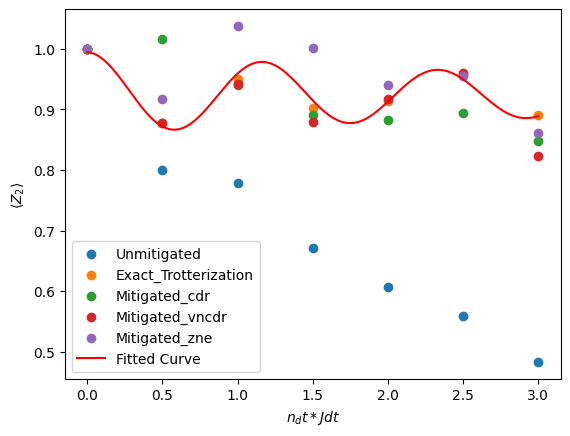

In [6]:
import matplotlib.pyplot as plt
import numpy
from scipy.optimize import curve_fit


# Define the average value function
def sigma_z_t(x, a_1, a_2, a_3, a_4, a_5):
    return a_1 * numpy.exp(-a_2 * x) * numpy.cos(a_3 * x) + a_4 * x + a_5


# Generate some sample data
x_data = np.linspace(0, n_dt * Jdt, n_dt + 1)

# Fit the cosine function to the data
popt, pcov = curve_fit(sigma_z_t, x_data, exact_measurement)

# Extract the optimized parameters
a_1_opt, a_2_opt, a_3_opt, a_4_opt, a_5_opt = popt

# Generate the fitted curve
x_fit = np.linspace(0, n_dt * Jdt, 300)
y_fit = sigma_z_t(x_fit, *popt)

# Plot the  data sets and the fitted curve
plt.scatter(x_data, unmitigated_measurement, label="Unmitigated")
plt.scatter(x_data, exact_measurement, label="Exact_Trotterization")
plt.scatter(x_data, mitigated_measurement_cdr, label="Mitigated_cdr")
plt.scatter(x_data, mitigated_measurement_vncdr, label="Mitigated_vncdr")
plt.scatter(x_data, mitigated_measurement_zne, label="Mitigated_zne")
plt.plot(x_fit, y_fit, "r-", label="Fitted Curve")
plt.xlabel(r"$n_dt*Jdt$")
plt.ylabel(r"$\langle Z_2 \rangle$")
plt.legend()
plt.show()

In [7]:
# Create qubits
qubits = cirq.LineQubit.range(L)

# Create a circuit
test_circuit = cirq.Circuit()

# initialize the input state in|00011>
test_circuit.append(cirq.I(qubits[0]))
test_circuit.append(cirq.I(qubits[1]))
test_circuit.append(cirq.I(qubits[2]))
test_circuit.append(cirq.X(qubits[3]))
test_circuit.append(cirq.X(qubits[4]))

# define the local observable
obs = Observable(PauliString("IIZII"))

# repeat the trotter evolution n_dt times and compute compute the unmitigated, exact and mitigated quantities for each step
unmitigated_measurement = [1]
exact_measurement = [1]
mitigated_measurement_cdr = [1]
mitigated_measurement_vncdr = [1]
mitigated_measurement_zne = [1]
for ii in range(n_dt):
    test_circuit += trotter_evolution_H(L, h_z, h_x, Jdt)
    unmitigated_measurement.append(
        obs.expectation(test_circuit, noisy_simulator).real
    )
    exact_measurement.append(obs.expectation(test_circuit, exact_simulator))
    mitigated_measurement_cdr.append(
        cdr.execute_with_cdr(
            test_circuit,
            noisy_simulator,
            observable=obs,
            simulator=exact_simulator,
        ).real
    )
    mitigated_measurement_vncdr.append(
        cdr.execute_with_cdr(
            test_circuit,
            noisy_simulator,
            observable=obs,
            simulator=exact_simulator,
            scale_factors=(1, 3),
        ).real
    )
    mitigated_measurement_zne.append(
        zne.execute_with_zne(
            test_circuit,
            noisy_simulator,
            observable=obs,
        ).real
    )

    # this is to keep track of how fast the simulation is
    print(ii)

0
1
2
3
4
5


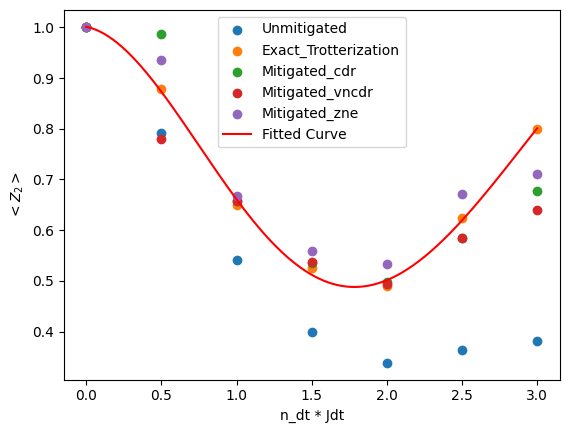

In [8]:
import numpy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Define the cosine function
def func(x, a_1, a_2, a_3, a_4, a_5):
    return a_1 * numpy.exp(-a_2 * x) * numpy.cos(a_3 * x) + a_4 * x + a_5


# Generate some sample data
x_data = np.linspace(0, n_dt * Jdt, n_dt + 1)

# Fit the cosine function to the data
popt, pcov = curve_fit(func, x_data, exact_measurement)

# Extract the optimized parameters
a_1_opt, a_2_opt, a_3_opt, a_4_opt, a_5_opt = popt

# Generate the fitted curve
x_fit = np.linspace(0, n_dt * Jdt, 300)
y_fit = func(x_fit, *popt)

# Plot the original data and the fitted curve
plt.scatter(x_data, unmitigated_measurement, label="Unmitigated")
plt.scatter(x_data, exact_measurement, label="Exact_Trotterization")
plt.scatter(x_data, mitigated_measurement_cdr, label="Mitigated_cdr")
plt.scatter(x_data, mitigated_measurement_vncdr, label="Mitigated_vncdr")
plt.scatter(x_data, mitigated_measurement_zne, label="Mitigated_zne")
plt.plot(x_fit, y_fit, "r-", label="Fitted Curve")
plt.xlabel("n_dt * Jdt")
plt.ylabel("$<Z_2>$")
plt.legend()
plt.show()

In [9]:
delta = [1] * 4

# define the \delta_i^zz observables
delta[0] = Observable(PauliString("ZZIII", -1 / 2), PauliString("I", 1 / 2))
delta[1] = Observable(PauliString("IZZII", -1 / 2), PauliString("I", 1 / 2))
delta[2] = Observable(PauliString("IIZZI", -1 / 2), PauliString("I", 1 / 2))
delta[3] = Observable(PauliString("IIIZZ", -1 / 2), PauliString("I", 1 / 2))

# Create qubits
qubits = cirq.LineQubit.range(L)

# Create a circuit
test_circuit = cirq.Circuit()

# initialize the input state in|00100>
test_circuit.append(cirq.I(qubits[0]))
test_circuit.append(cirq.I(qubits[1]))
test_circuit.append(cirq.X(qubits[2]))
test_circuit.append(cirq.I(qubits[3]))
test_circuit.append(cirq.I(qubits[4]))

# for each mitigation method we need a 4*n_dt matrix to save the results
unmitigated_measurement = [[1] * (n_dt) for _ in range(4)]
exact_measurement = [[1] * (n_dt) for _ in range(4)]
mitigated_measurement_cdr = [[1] * (n_dt) for _ in range(4)]
mitigated_measurement_vncdr = [[1] * (n_dt) for _ in range(4)]
mitigated_measurement_zne = [[1] * (n_dt) for _ in range(4)]

# repeat the trotter evolution n_dt times and compute compute the unmitigated, exact and mitigated quantities for each step
for ii in range(n_dt):
    for jj in range(4):
        unmitigated_measurement[jj][ii] = (
            delta[jj].expectation(test_circuit, noisy_simulator).real
        )
        exact_measurement[jj][ii] = delta[jj].expectation(
            test_circuit, exact_simulator
        )
        mitigated_measurement_cdr[jj][ii] = cdr.execute_with_cdr(
            test_circuit,
            noisy_simulator,
            observable=delta[jj],
            simulator=exact_simulator,
        ).real
        mitigated_measurement_vncdr[jj][ii] = cdr.execute_with_cdr(
            test_circuit,
            noisy_simulator,
            observable=delta[jj],
            simulator=exact_simulator,
            scale_factors=(1, 3),
        ).real
        mitigated_measurement_zne[jj][ii] = zne.execute_with_zne(
            test_circuit,
            noisy_simulator,
            observable=delta[jj],
        ).real
    test_circuit += trotter_evolution_H(L, h_z, h_x, Jdt)

    print(ii)

0
1
2
3
4
5


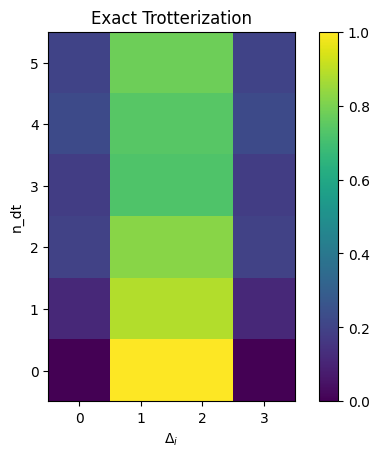

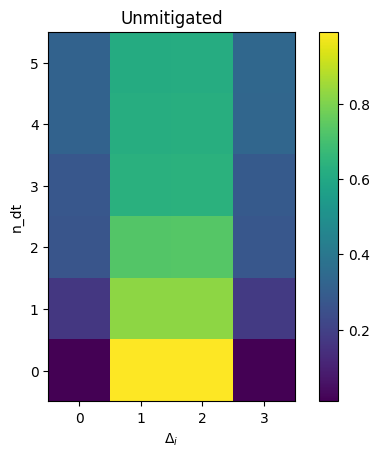

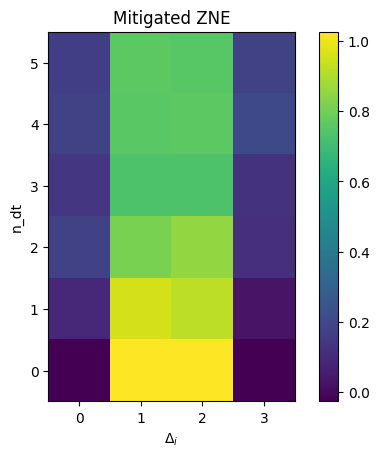

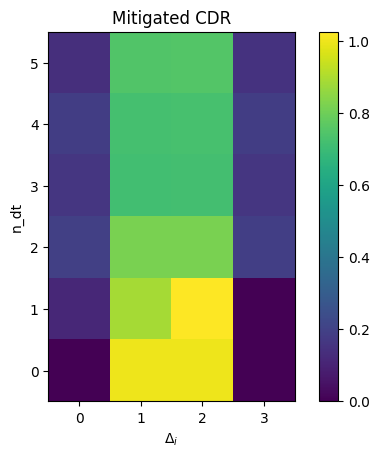

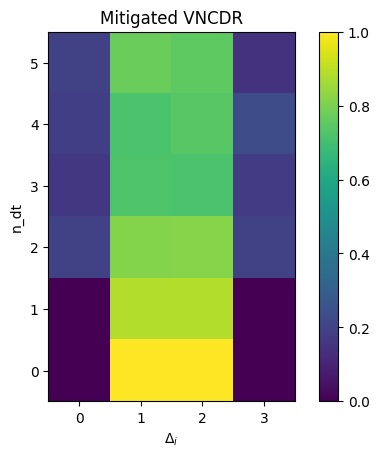

In [10]:
# Plot exact_measurement using colors
plt.imshow(np.transpose(exact_measurement), cmap="viridis")

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a title
plt.title("Exact Trotterization")

# Add x and y labels
plt.xlabel(r"$\Delta_i$")
plt.ylabel("n_dt")

# Add a colorbar for reference
plt.colorbar()

# Show the plot
plt.show()

# Plot unmitigated_measurement using colors
plt.imshow(np.transpose(unmitigated_measurement), cmap="viridis")

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a title
plt.title("Unmitigated")

# Add x and y labels
plt.xlabel(r"$\Delta_i$")
plt.ylabel("n_dt")

# Add a colorbar for reference
plt.colorbar()

# Show the plot
plt.show()


# Plot mitigated_measurement_zne using colors
plt.imshow(np.transpose(mitigated_measurement_zne), cmap="viridis")

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a title
plt.title("Mitigated ZNE")

# Add x and y labels
plt.xlabel(r"$\Delta_i$")
plt.ylabel("n_dt")

# Add a colorbar for reference
plt.colorbar()

# Show the plot
plt.show()


# Plot mitigated_measurement_cdr using colors
plt.imshow(np.transpose(mitigated_measurement_cdr), cmap="viridis")

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a title
plt.title("Mitigated CDR")

# Add x and y labels
plt.xlabel(r"$\Delta_i$")
plt.ylabel("n_dt")

# Add a colorbar for reference
plt.colorbar()

# Show the plot
plt.show()

# Plot mitigated_measurement_vncdr using colors
plt.imshow(np.transpose(mitigated_measurement_vncdr), cmap="viridis")

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a title
plt.title("Mitigated VNCDR")

# Add x and y labels
plt.xlabel(r"$\Delta_i$")
plt.ylabel("n_dt")

# Add a colorbar for reference
plt.colorbar()

# Show the plot
plt.show()

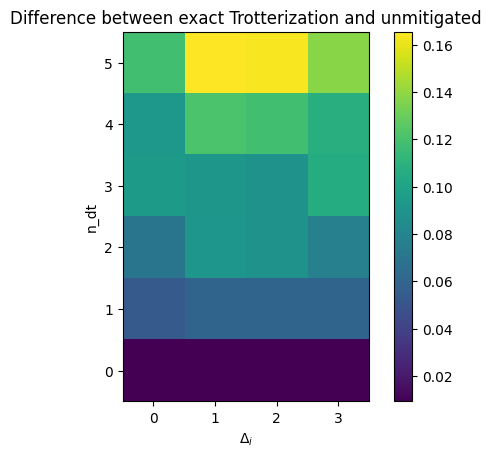

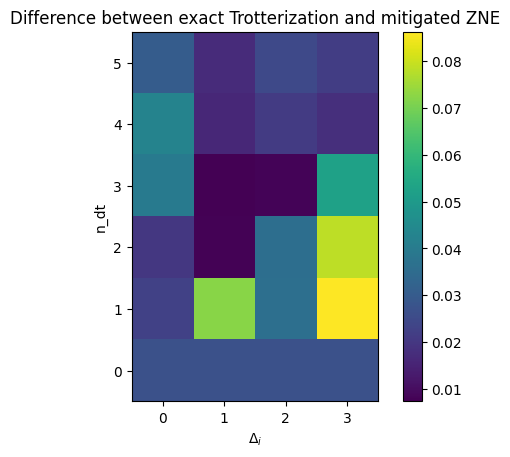

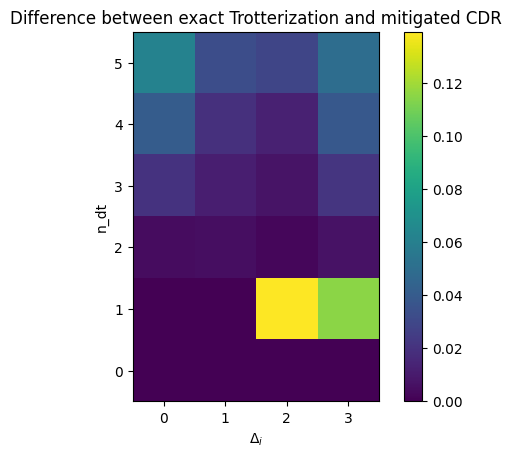

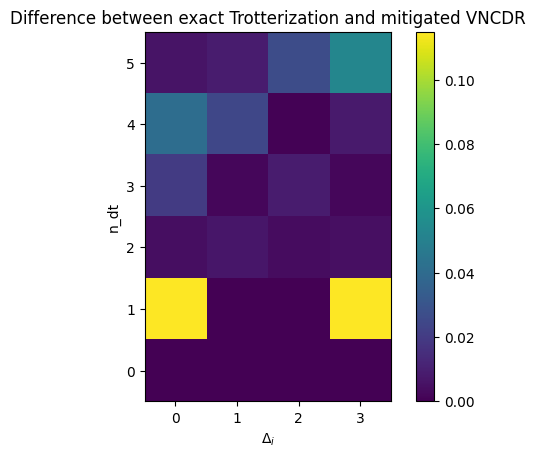

In [11]:
# Plot the difference between exact and unmitigated_measurement using colors
plt.imshow(
    np.abs(
        np.transpose(exact_measurement) - np.transpose(unmitigated_measurement)
    ),
    cmap="viridis",
)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a title
plt.title("Difference between exact Trotterization and unmitigated")

# Add x and y labels
plt.xlabel(r"$\Delta_i$")
plt.ylabel("n_dt")

# Add a colorbar for reference
plt.colorbar()

# Show the plot
plt.show()

# Plot the difference between exact and mitigated_measurement_zne using colors
plt.imshow(
    np.abs(
        np.transpose(exact_measurement)
        - np.transpose(mitigated_measurement_zne)
    ),
    cmap="viridis",
)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a title
plt.title("Difference between exact Trotterization and mitigated ZNE")

# Add x and y labels
plt.xlabel(r"$\Delta_i$")
plt.ylabel("n_dt")

# Add a colorbar for reference
plt.colorbar()

# Show the plot
plt.show()

# Plot the difference between exact and mitigated_measurement_cdr using colors
plt.imshow(
    np.abs(
        np.transpose(exact_measurement)
        - np.transpose(mitigated_measurement_cdr)
    ),
    cmap="viridis",
)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a title
plt.title("Difference between exact Trotterization and mitigated CDR")

# Add x and y labels
plt.xlabel(r"$\Delta_i$")
plt.ylabel("n_dt")

# Add a colorbar for reference
plt.colorbar()

# Show the plot
plt.show()

# Plot the difference between exact and mitigated_measurement_vncdr using colors
plt.imshow(
    np.abs(
        np.transpose(exact_measurement)
        - np.transpose(mitigated_measurement_vncdr)
    ),
    cmap="viridis",
)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a title
plt.title("Difference between exact Trotterization and mitigated VNCDR")

# Add x and y labels
plt.xlabel(r"$\Delta_i$")
plt.ylabel("n_dt")

# Add a colorbar for reference
plt.colorbar()

# Show the plot
plt.show()